# Introduction to Performance and Parallel Computing

_Find and release the brakes_

Milan Klöwer, Massachusetts Institute of Technology

Julia EO, Global Workshop on Earth Observation with Julia 2024

# Part 1: Performance

Julia is (usually) fast. But how to be sure you don't have the brakes on?

- Example
- Benchmarking
- Intermediate representations
- Memory allocations and garbage collection
- Common pitfalls


## Example: Gaussian

Calculate some Gaussian over any inputs `x`

$
f(x) = \frac{1}{\sigma\sqrt{2\pi}} \exp\left(-\frac{1}{2}\left(\frac{x-\mu}{\sigma}\right)^2\right)
$

In [ ]:
function gaussian(x, μ=0, σ=1)
    return @. 1/(σ*√(2π)) * exp(-1/2 * ((x-μ)/σ)^2)
end

Now evalulate `gaussian` for values between -3 and 3

In [ ]:
x = collect(-3:0.01:3)
g = gaussian(x)

In [ ]:
using CairoMakie
plot(x,g)

So it does the right thing, but is it fast? How do I know it's fast? And if not, what is the bottle neck?

## Example: Gaussian

Julia has the `@time` macro, that puts a timer around the evaluation of whatever follows.

In [ ]:
@time gaussian(x);

That would be 23μs, but is this measurement robust? And how do I know how Julia actually translates `gaussian` for my input `x::Vector{Float64}`?

In [ ]:
y = Float32.(x)
gaussian(y)    # triggers compilation
@time g2 = gaussian(y);

Why am I not saving memory? And is it faster? Not sure ...

## Example: Gaussian

Maybe let's do it like C/Fortran and be more specific, declare many things, explicit loops, precompute stuff, ...

In [ ]:
function gaussian_oldschool(x::Array{Float64},μ=0.0,σ=1.0)
    
    n = size(x)
    g = Array{Float64}(undef,n...)    # allocate output
    c = 1/(σ*sqrt(2*π))               # precompute scaling constant

    for i in 1:length(x)
        g[i] = c*exp(-1/2*((x[i]-μ)/σ)^2)
    end

    return g
end

In [ ]:
gaussian_oldschool(x)    # triggers compilation
@time gaussian_oldschool(x);

In [ ]:
@time gaussian_oldschool(y)

But my abstractions!! We obviously want generic and fast code, so that might not be the way to do it? Let's measure it!!

# 1.1 Benchmarking

Previously, we only had the following information

In [ ]:
@time rand(100);

Now, we want to use BenchmarkTools.jl

In [ ]:
using BenchmarkTools
BenchmarkTools.DEFAULT_PARAMETERS.seconds = 1;

In [ ]:
@btime rand(100);

In [ ]:
@benchmark rand(100)

Globals should get a `$` for more accurate measurement

In [ ]:
@btime gaussian($x);

In [ ]:
@btime gaussian_oldschool($x);

## 1.3 Intermediate representations

Question, which one is faster?

In [ ]:
f1(x,y) = x*ℯ^y
f2(x,y) = x*exp(y)
f3(x,y) = x*exp(1)^y

We can investigate the compiled code with `@code_llvm`, we have
- Julia code ->
- Typed code (`@code_typed`) ->
- Lowered code (`@code_lowered`) ->
- LLVM code (`@code_llvm`) ->
- Assembly code (`@code_native`) ->
- Machine code

In [ ]:
@code_llvm f1(1.5,2.0)

In [ ]:
@code_llvm f2(1.5,2.0)

In [ ]:
@code_llvm f3(1.5,2.0)

## 1.4 Allocation and garbage collection

Keep an eye on memory that needs to be allocated and garbage collected if no longer used

In [ ]:
using LinearAlgebra
A = rand(1000,1000);    # 8MB array

Two functions that are mathematically identical

In [ ]:
function matrix_norm_v1(A)
    LinearAlgebra.norm(2A)   # 2A has to be allocated and stored
end                          # but is garbage collected afterwards

function matrix_norm_v2(A)
    2*LinearAlgebra.norm(A)  # scalar multiply only
end

But with very different timings because of additional allocation and subsequent garbage collection

In [ ]:
@btime matrix_norm_v1($A)

In [ ]:
@btime matrix_norm_v2($A)

### Consider in-place operations! or views for big data

This avoids allocations but overwrites inputs (not always desired)

In [ ]:
using FFTW
z = randn(Complex{Float64},1000_000)
@btime ifft(fft($z));

In [ ]:
@btime ifft!(fft!($z));

## 1.5 Common pitfalls: Unnecessary argument types

Functions are compiled to specific argument types anyway, whether or not you constrain them for multiple dispatch

In [ ]:
a1(x) = x*inv(x)
a2(x::Float64) = x*inv(x)

In [ ]:
@code_llvm a1(1.0)

In [ ]:
@code_llvm a2(1.0)

Bonus question: Why are these not compiled to `one(x)`?

## 1.5 Common pitfalls: Abstract fields

One might be tempted to define abstract fields for new compound types with `struct`

In [ ]:
abstract type PointExample end

struct PointNumber <: PointExample
    x::Number
    y::Number
end

In [ ]:
struct PointInteger <: PointExample
    x::Int64
    y::Int64
end

In [ ]:
Base.length(p::PointExample) = sqrt(p.x^2 + p.y^2)

In [ ]:
p1 = PointNumber(1,2)
p2 = PointInteger(1,2)

But for abstract fields (`::Number` here) the compiler does not know what to expect, 8bit? 64bit? 1024bit? And therefore has to check types for allocations at runtime. 4x slower here, very bad.

In [ ]:
@btime length(p1);

In [ ]:
@btime length(p2);

# Part 2: Parallel

A little introduction to multi-threading and distributed computing

## 2.1 Multi-threading

Think about several processors working independently but using the same memory

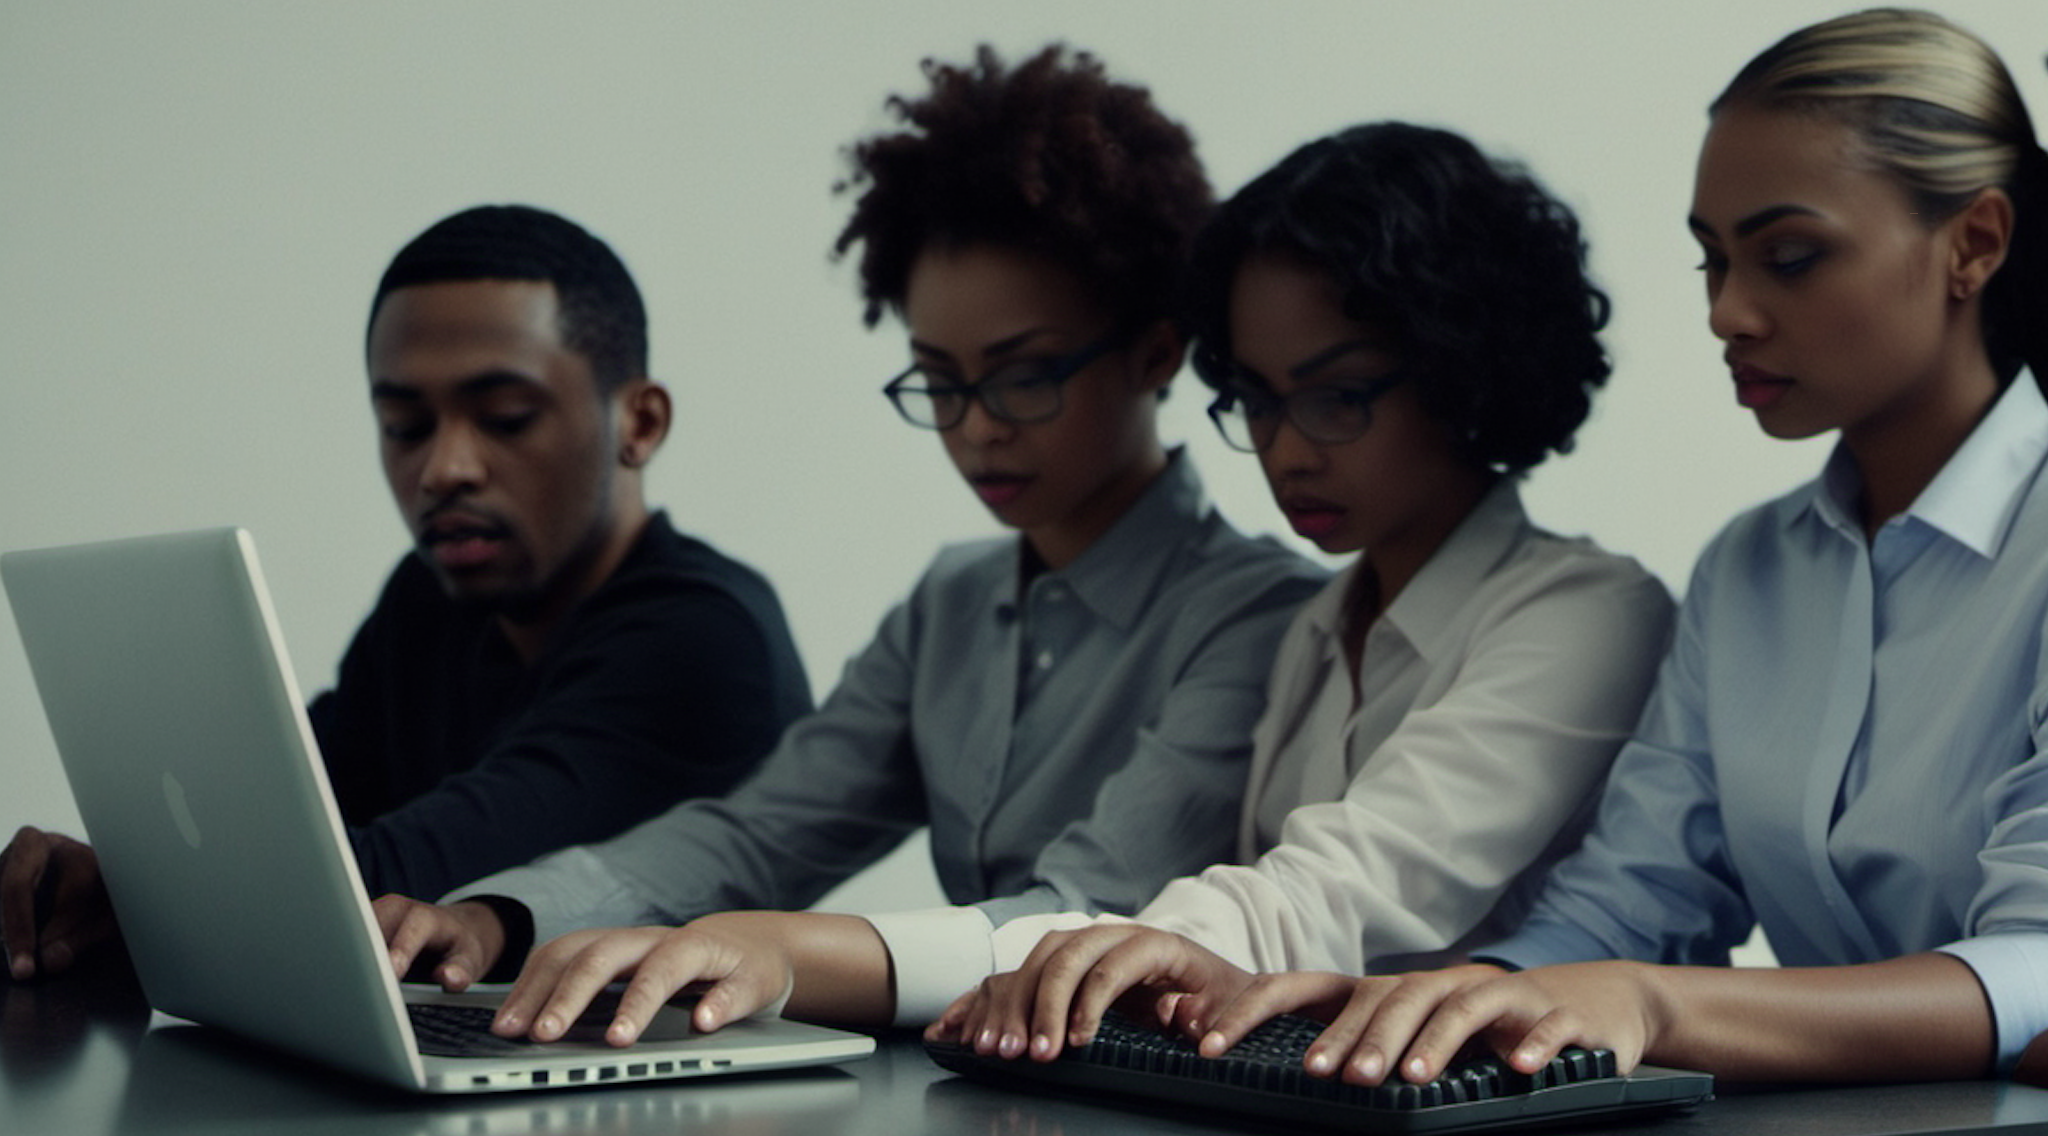

Start Julia with 4 threads
`julia --threads 4`

In [ ]:
Threads.nthreads()

Now we can use 4 threads (~4 processors) each with an id 1,2,3 or 4

In [ ]:
n = 10
v = zeros(Int,n)

Threads.@threads for i in 1:n
    v[i] = Threads.threadid()
end

In [ ]:
v

### Data race conditions

What happens if several processors access the same memory simultaneously?

In [ ]:
function race(n)
    a = 0
    Threads.@threads for i in 1:n
        a += 1
    end
    return a
end

In [ ]:
race(100_000)

Probably not what you expected. That's a race condition.

Example race condition (from Wikipedia)

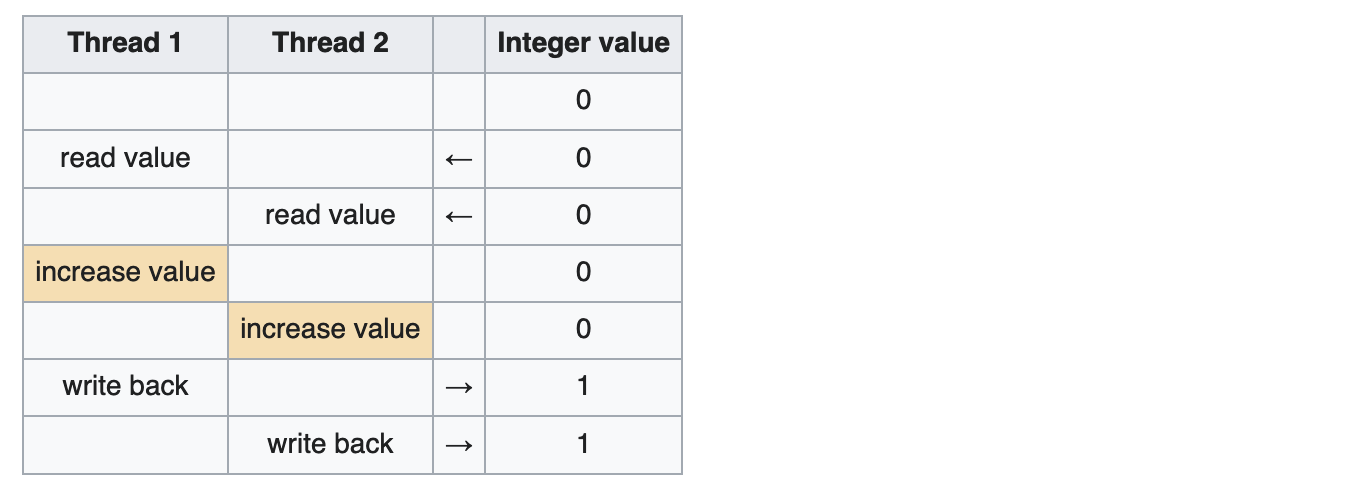

Safe use of threads with no overlapping data access:

In [ ]:
n,m = 10,10
A = randn(n,m)

Threads.@threads for i in 1:m
    column = view(A,:,i)    # because A[:,i] would create a copy
    sort!(column)
end

A

## 2.2 Distributed parallelism

Now we turn to N processors with __independent__ memory. Richardson's weather forecast with human computers distributed on the inside of a sphere

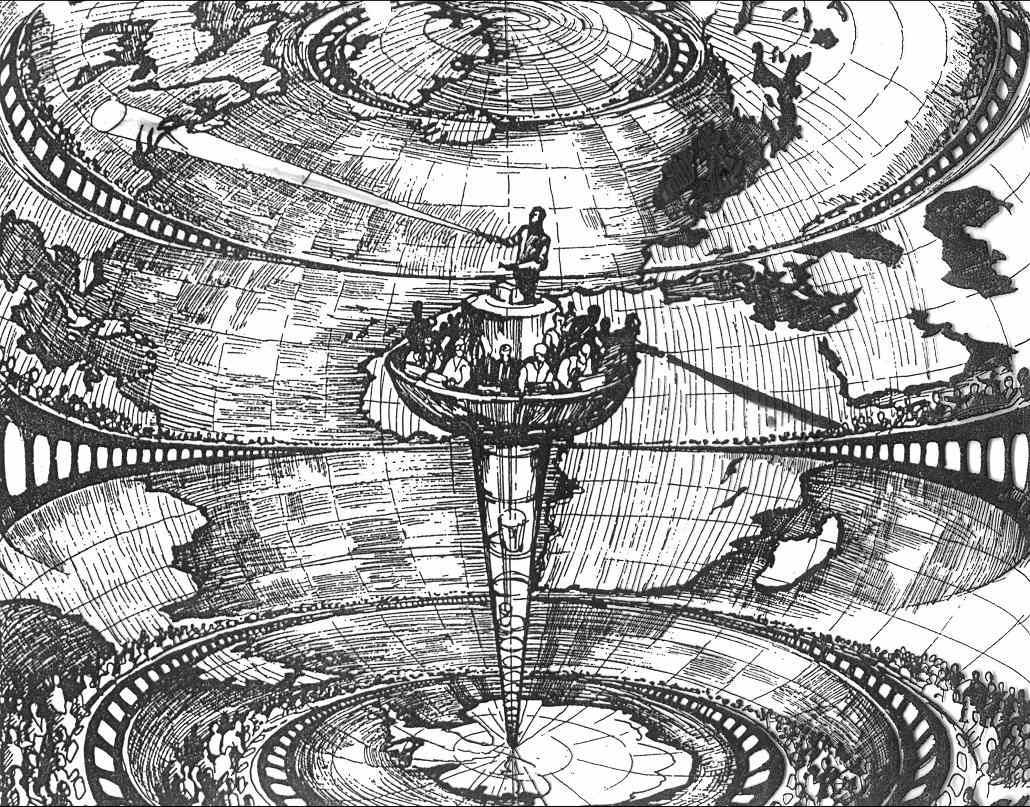

Let's add some workers

In [ ]:
using Distributed

In [ ]:
Distributed.addprocs(4)

Now we have some workers with ids 2,3,4,...

### Distributed prime factorization

Distribute across workers, seemingly similar to multi-threading

In [ ]:
@everywhere using Primes

@distributed for i in 1_000_000:1_000_010
    
    # do a prime factorization
    factors = Primes.factor(i)

    # pretty printing
    println("$i = "*repr("text/plain",factors))
end

### MapReduce framework, example 1

Distribute (=map) across workers, but "gather" in a reduction function

In [ ]:
nheads = @distributed (+) for i = 1:1000
    rand(Bool)
end

4 workers have tossed 1000 coins with ~50% tail! Yay!

### MapReduce framework, example 2
Distribute 100 years of data across workers, let them find the highest wind speed in each year and reduce to highest wind speed over all 100 years

In [ ]:
years = 1900:2000

strongest_wind = @distributed max for year in years
    daily_wind_speed = randn(365)    # or load some data
    maximum(daily_wind_speed)
end

## Domain decomposition

Earth system simulations often decompose the sphere into N domains with communication across edges

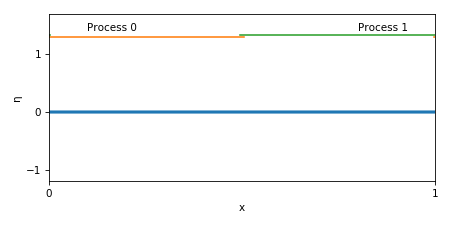

Domain 0 holds a ghost point across the edge which domain 1 writes into on every time step, and vice versa. 